# Case Study Five: SVM & SGD
## By: Allen Hoskins & Brittany Lewandowski

In [1]:
#Importing required libraries:

import pandas as pd
import io 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score, confusion_matrix
from scipy import stats

In [2]:
log_df = pd.read_csv(r'../data_sets/log2.csv')

In [3]:
#Viewing general data related infromation:

display(log_df.info())
display(log_df.describe())
display(log_df.dtypes.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


None

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
mean,49391.969343,10577.385812,19282.972761,2671.049930,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000
max,65534.000000,65535.000000,65535.000000,65535.000000,1.269359e+09,9.484772e+08,3.208818e+08,1.036116e+06,10824.000000,747520.000000,327208.000000


int64     11
object     1
dtype: int64

In [4]:
#Viewing missing values in our data frame:

log_df.isna().sum()

Source Port             0
Destination Port        0
NAT Source Port         0
NAT Destination Port    0
Action                  0
Bytes                   0
Bytes Sent              0
Bytes Received          0
Packets                 0
Elapsed Time (sec)      0
pkts_sent               0
pkts_received           0
dtype: int64

In [5]:
#Re-naming columns:
log_df.rename(columns = {'Source Port':'source_port','Destination Port':'destination_port','NAT Source Port':'nat_source_port',
                         'NAT Destination Port':'nat_destination_port','Bytes Sent':'bytes_sent','Bytes Received':'bytes_receieved',
                         'Elapsed Time (sec)':'elapsed_time','Bytes':'bytes','Packets':'packets'},inplace = True)
log_df.head()

,source_port,destination_port,nat_source_port,nat_destination_port,Action,bytes,bytes_sent,bytes_receieved,packets,elapsed_time,pkts_sent,pkts_received
0,57222,53,54587,53,allow,177,94,83,2,30,1,1
1,56258,3389,56258,3389,allow,4768,1600,3168,19,17,10,9
2,6881,50321,43265,50321,allow,238,118,120,2,1199,1,1
3,50553,3389,50553,3389,allow,3327,1438,1889,15,17,8,7
4,50002,443,45848,443,allow,25358,6778,18580,31,16,13,18


In [6]:
#Converting data types of "Port" columns:

log_df['source_port'] = log_df.source_port.astype('object')
log_df['destination_port'] = log_df.destination_port.astype('object')
log_df['nat_source_port'] = log_df.nat_source_port.astype('object')
log_df['nat_destination_port'] = log_df.nat_destination_port.astype('object')

In [7]:
#Separating data into numeric and categorical columns:

num_df = log_df.select_dtypes(include=np.number)
cat_df = log_df.select_dtypes(include=['object'])

## EDA:

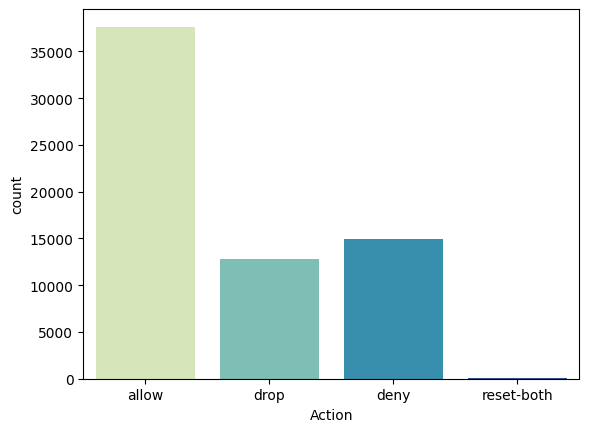

In [8]:
#Viewing the distribution of our response:

sns.countplot(x='Action',data=log_df,palette='YlGnBu')
plt.show()

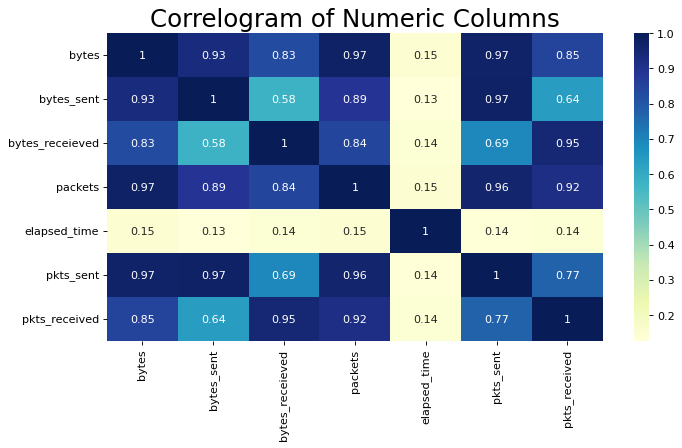

In [9]:
# Creating a correlation plot of our numeric features:

plt.figure(figsize=(10,5), dpi= 80)
corr1 = log_df.corr()
sns.heatmap(corr1,
            cmap = "YlGnBu",
            annot=True,
            annot_kws ={'size':10})    
plt.title('Correlogram of Numeric Columns', fontsize=22)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

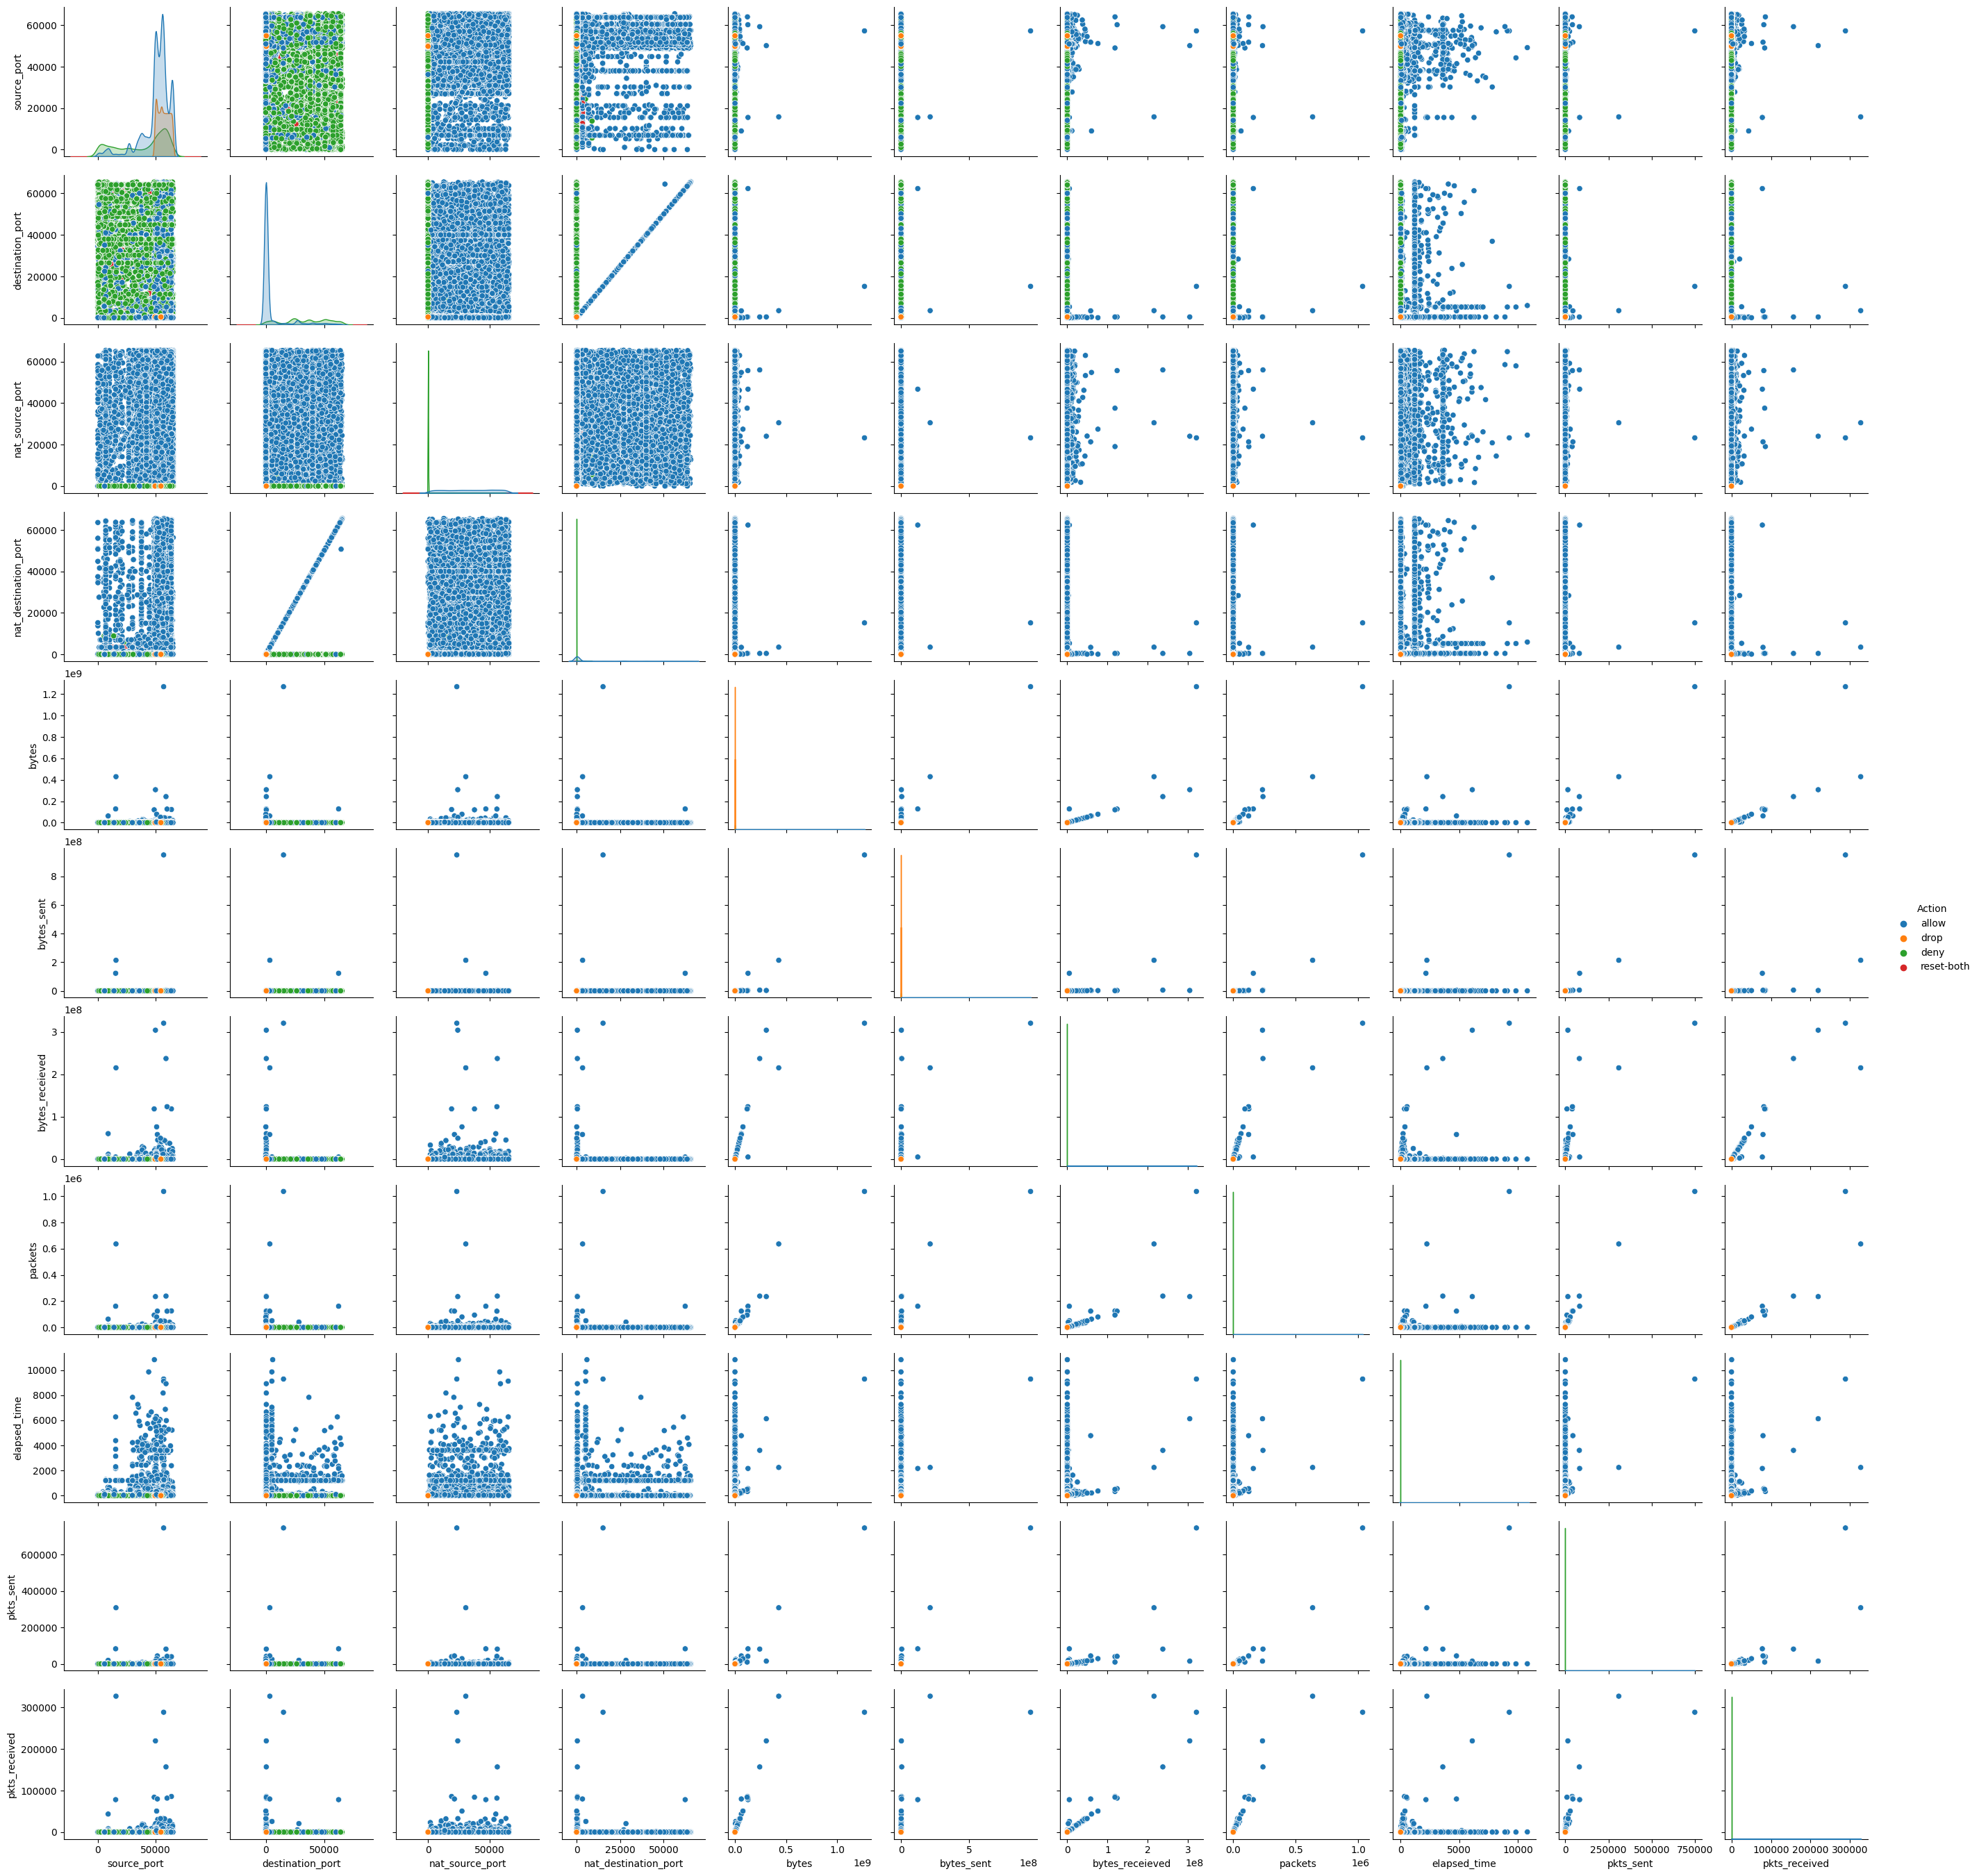

In [10]:
#Creating pairplots of our log_df dat frame to view our variable distributions:

sns.pairplot(log_df, hue ='Action')
plt.show()

## Re-Coding Categorical Variables:

In [11]:
#For loop to calculate the counts of each categorical variable in our cat_df DF:

for col in cat_df.columns:
    if cat_df[col].dtype == 'object':
        print(cat_df[col].value_counts()/len(cat_df)*100)

58638    1.281817
27005    0.782824
443      0.416590
57470    0.338766
49418    0.320454
           ...   
32996    0.001526
60574    0.001526
60570    0.001526
65368    0.001526
54871    0.001526
Name: source_port, Length: 22724, dtype: float64
53       23.521333
445      19.671306
443      17.829457
80        6.157297
25174     1.658732
           ...    
20009     0.001526
48608     0.001526
10016     0.001526
13384     0.001526
22455     0.001526
Name: destination_port, Length: 3273, dtype: float64
0        43.386437
48817     0.126656
58638     0.077825
50116     0.022890
7986      0.007630
           ...    
2063      0.001526
33661     0.001526
36797     0.001526
14122     0.001526
13485     0.001526
Name: nat_source_port, Length: 29152, dtype: float64
0        43.386437
53       23.033022
443      17.820302
80        6.146615
27015     0.357077
           ...    
45561     0.001526
45738     0.001526
41872     0.001526
25760     0.001526
32277     0.001526
Name: nat_destinatio

In [12]:
cat_df = log_df.select_dtypes(include=['object'])

In [13]:
#Re-coding our source_port variable: 0.4

cat_df['source_port']=cat_df['source_port'].mask(cat_df['source_port'].map(cat_df['source_port'].value_counts(normalize=True)) < .00021, 'Other')
cat_df.source_port.value_counts(normalize=True, ascending=False) #Viewing results of our 'source_port' column.

Other    0.919368
58638    0.012818
27005    0.007828
443      0.004166
57470    0.003388
           ...   
54998    0.000214
56658    0.000214
49369    0.000214
43129    0.000214
49845    0.000214
Name: source_port, Length: 101, dtype: float64

In [14]:
#Re-coding our nat_source_port variable:

cat_df['nat_source_port']=cat_df['nat_source_port'].mask(cat_df['nat_source_port'].map(cat_df['nat_source_port'].value_counts(normalize=True)) < .00004, 'Other')
cat_df.nat_source_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

Other    0.518434
0        0.433864
48817    0.001267
58638    0.000778
50116    0.000229
           ...   
55689    0.000046
61837    0.000046
38830    0.000046
63046    0.000046
55530    0.000046
Name: nat_source_port, Length: 961, dtype: float64

In [15]:
#Re-coding our destination_port variable:

cat_df['destination_port']=cat_df['destination_port'].mask(cat_df['destination_port'].map(cat_df['destination_port'].value_counts(normalize=True)) < .004, 'Other')
cat_df.destination_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

53       0.235213
Other    0.199277
445      0.196713
443      0.178295
80       0.061573
25174    0.016587
5900     0.013871
37965    0.012605
22114    0.011704
64147    0.011536
50584    0.010941
57470    0.010239
44847    0.009553
35440    0.006531
51505    0.005722
26467    0.005661
23       0.005539
56205    0.004395
30188    0.004044
Name: destination_port, dtype: float64

In [16]:
#Re-coding our nat_destination_port variable:

cat_df['nat_destination_port']=cat_df['nat_destination_port'].mask(cat_df['nat_destination_port'].map(cat_df['nat_destination_port'].value_counts(normalize=True)) < .1, 'Other')
cat_df.nat_destination_port.value_counts(normalize=True, ascending=False) #Viewing results of our re-coded race column.

0        0.433864
53       0.230330
443      0.178203
Other    0.157602
Name: nat_destination_port, dtype: float64

## OHE:

In [17]:
#Grabbing categorical columns from our cat_final DF for OHE:

column_names_for_onehot = cat_df.columns[0:4]
column_names_for_onehot #Verifying all of our columns are in our variable.

Index(['source_port', 'destination_port', 'nat_source_port',
       'nat_destination_port'],
      dtype='object')

In [18]:
#Performing OHE on our categorical columns:

cat_ohe = pd.get_dummies(cat_df, columns=column_names_for_onehot, drop_first=False)

In [19]:
log_final = num_df.join(cat_ohe)
pd.set_option('display.max_columns', None)
log_final

bytes  bytes_sent  bytes_receieved  packets  elapsed_time  pkts_sent  \
0          177          94               83        2            30          1   
1         4768        1600             3168       19            17         10   
2          238         118              120        2          1199          1   
3         3327        1438             1889       15            17          8   
4        25358        6778            18580       31            16         13   
...        ...         ...              ...      ...           ...        ...   
65527      314         192              122        6            15          4   
65528  4680740       67312          4613428     4675            77        985   
65529       70          70                0        1             0          1   
65530       70          70                0        1             0          1   
65531       70          70                0        1             0          1   

       pkts_received Action  source_port_0  source_port_80  source_port_123  \
0                  1  allow              0               0                0   
1                  9  allow              0               0                0   
2                  1  allow              0               0                0   
3                  7  allow              0               0                0   
4                 18  allow              0               0                0   
...              ...    ...            ...             ...              ...   
65527              2  allow              0               0                0   
65528           3690  allow              0               0                0   
65529              0   drop              0               0                0   
65530              0   drop              0               0                0   
65531              0   drop              0               0                0   

       source_port_443  source_port_993  source_port_1024  source_port_1025  \
0                    0                0                 0                 0   
1                    0                0                 0                 0   
2                    0                0                 0                 0   
3                    0                0                 0                 0   
4                    0                0                 0                 0   
...                ...              ...               ...               ...   
65527                0                0                 0                 0   
65528                0                0                 0                 0   
65529                0                0                 0                 0   
65530                0                0                 0                 0   
65531                0                0                 0                 0   

       source_port_1027  source_port_2267  source_port_3478  source_port_5222  \
0                     0                 0                 0                 0   
1                     0                 0                 0                 0   
2                     0                 0                 0                 0   
3                     0                 0                 0                 0   
4                     0                 0                 0                 0   
...                 ...               ...               ...               ...   
65527                 0                 0                 0                 0   
65528                 0                 0                 0                 0   
65529                 0                 0                 0                 0   
65530                 0                 0                 0                 0   
65531                 0                 0                 0                 0   

       source_port_5223  source_port_5588  source_port_5938  source_port_6666  \
0                     0                 0                 0                 0   
1  

## SVM Modeling

In [20]:
#Setting a seed:

np.random.seed(1234)

In [21]:
#Splitting feature columns from our response:

X = log_final.loc[:, log_final.columns != 'Action']
y = log_final['Action']

In [22]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=0)

In [23]:
#Scaling data:

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train) 
X_test = scaler.fit_transform(X_test) 

In [24]:
#Fitting SVM models:

linear = svm.SVC(kernel='linear', gamma=0.5, C=0.1).fit(X_train, y_train)

In [25]:
#Generating predictions on our linear model:

linear_pred = linear.predict(X_test)

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.99      0.99      0.99      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

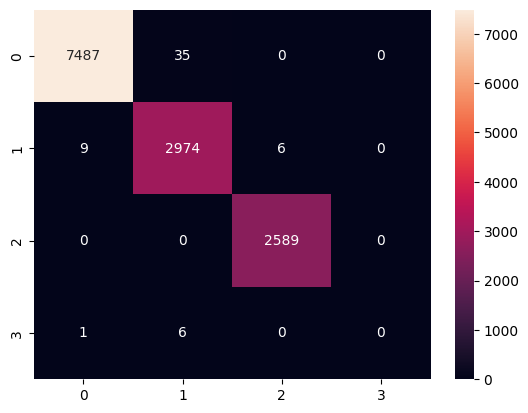

In [26]:
#Confusion report for linear model:

print(classification_report(y_test,linear_pred))
cm = confusion_matrix(y_test, linear_pred)
linear_cm = sns.heatmap(cm, annot=True, fmt='d')
linear_cm

In [27]:
# SVM with polynomial kernel:

poly = svm.SVC(kernel='poly', gamma=0.5, C=0.1).fit(X_train, y_train)

In [28]:
poly_pred = poly.predict(X_test)

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.99      0.99      0.99      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

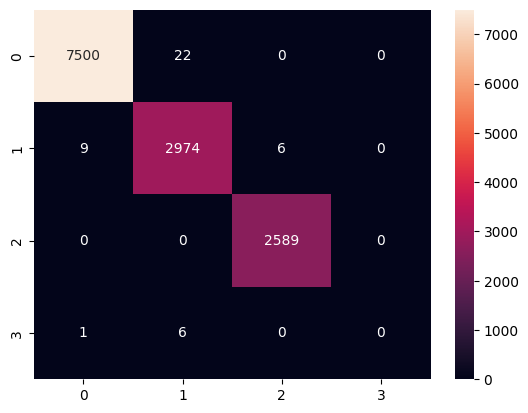

In [29]:
#Confusion report for poly model:

print(classification_report(y_test,poly_pred))
cm = confusion_matrix(y_test, poly_pred)
poly_cm = sns.heatmap(cm, annot=True, fmt='d')
poly_cm

In [30]:
#Testing a value of C=0.5 for our poly kernel:

poly2 = svm.SVC(kernel='poly', gamma=0.5, C=0.5).fit(X_train, y_train)

In [31]:
poly_pred2 = poly2.predict(X_test)

              precision    recall  f1-score   support

       allow       1.00      1.00      1.00      7522
        deny       0.99      1.00      0.99      2989
        drop       1.00      1.00      1.00      2589
  reset-both       0.00      0.00      0.00         7

    accuracy                           1.00     13107
   macro avg       0.75      0.75      0.75     13107
weighted avg       1.00      1.00      1.00     13107



/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

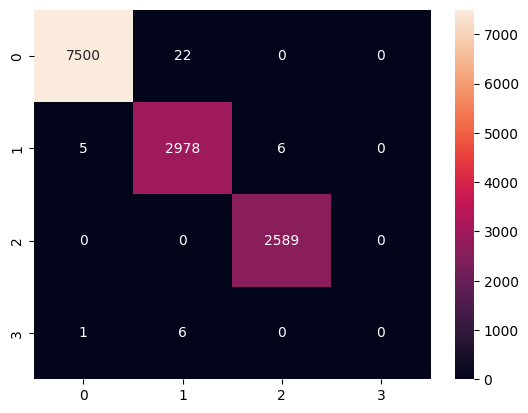

In [32]:
#Confusion report for poly model:

print(classification_report(y_test,poly_pred2))
cm = confusion_matrix(y_test, poly_pred2)
poly_cm2 = sns.heatmap(cm, annot=True, fmt='d')
poly_cm2

*** 
# Begin Vow Pal Wabbit Modeling:

In [33]:
import vowpalwabbit as vw
from vowpalwabbit.dftovw import DFtoVW
from vowpalwabbit import Workspace

In [56]:
vw_df = log_final.copy()

In [59]:
action_vals = list(vw_df['Action'].unique())

vw_df['Action'].replace(action_vals,
                        [1, 2, 3, 4],
                        inplace=True
                        )

vw_df['Action'].unique()

In [64]:
vw_X = list(vw_df.columns[vw_df.columns != 'Action'])
vw_y = list(vw_df.columns[vw_df.columns == 'Action'])

In [89]:
vpw_train, vpw_test = train_test_split(
                                        vw_df, 
                                        test_size=0.2,
                                        random_state= 0
                                      )

In [91]:
train_converter = DFtoVW.from_column_names(df=vpw_train, y=vw_y, x=vw_X)
test_converter = DFtoVW.from_column_names(df=vpw_test, y=vw_y, x=vw_X)

In [92]:
test = test_converter.convert_df()
train = train_converter.convert_df()

In [93]:
test[:1]

['1 | bytes:489 bytes_sent:88 bytes_receieved:401 packets:4 elapsed_time:46 pkts_sent:2 pkts_received:2 source_port_0:0 source_port_80:0 source_port_123:0 source_port_443:0 source_port_993:0 source_port_1024:0 source_port_1025:0 source_port_1027:0 source_port_2267:0 source_port_3478:0 source_port_5222:0 source_port_5223:0 source_port_5588:0 source_port_5938:0 source_port_6666:0 source_port_6712:0 source_port_6881:0 source_port_6882:0 source_port_6889:0 source_port_8889:0 source_port_8999:0 source_port_10151:0 source_port_10669:0 source_port_11136:0 source_port_13285:0 source_port_15503:0 source_port_16387:0 source_port_17750:0 source_port_19473:0 source_port_19875:0 source_port_21133:0 source_port_25565:0 source_port_26900:0 source_port_27005:0 source_port_27988:0 source_port_30188:0 source_port_30960:0 source_port_37965:0 source_port_40204:0 source_port_42252:0 source_port_42298:0 source_port_43129:0 source_port_43584:0 source_port_44847:0 source_port_45682:0 source_port_45908:0 sourc

In [94]:
model = Workspace(quiet=True,enable_logging=True)

for l in train:
    model.learn(l)

model.finish()

In [119]:
predictions = []
for p in test:
    predicted_class = round(model.predict(p))
    predictions.append(predicted_class)

In [120]:
predictions[:15]

[1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 1, 3, 1, 2, 1]

In [125]:
actuals = []
for i in range(len(test)):
    actual = int(test[i][:1])
    actuals.append(actual)

In [126]:
print(classification_report(actuals,predictions))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00      7519
           2       0.99      1.00      0.99      2573
           3       0.99      0.99      0.99      3005
           4       0.00      0.00      0.00        10

    accuracy                           1.00     13107
   macro avg       0.74      0.75      0.75     13107
weighted avg       0.99      1.00      0.99     13107



/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/allen/virtualenvs/QTW/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
